**About the dataset**

The dataset can be found in Kaggle using the following link :
https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

In [194]:
pip install opendatasets --upgrade --quiet

In [195]:
#Import dataset
import opendatasets as od

download_url = 'https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis'

od.download(download_url)

Skipping, found downloaded files in "./customer-personality-analysis" (use force=True to force download)


In [196]:
data_filename = '/content/customer-personality-analysis/marketing_campaign.csv'

**Libraries**


In [197]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pickle

import warnings
warnings.filterwarnings('ignore')

**Data general overview**

In [198]:
df = pd.read_csv(data_filename,sep="\t")

In [199]:
print("shape of the data :",df.shape)
df.head()

shape of the data : (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [201]:
#check for null values
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

**Feature engineering and Data preprocessing**

In [202]:
# Drop all null values in dataset
df = df.dropna()

In [203]:
# converting columns to DateTime format
df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format ='%Y')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

**Creating additional columns**

In [204]:
# Create a feature with the age
df['Age'] = 2021 - df['Year_Birth'].dt.year 

In [205]:
# Create a feature with the number of children
df['children'] = df['Kidhome'] + df['Teenhome']

In [206]:
# Create a feature with the total spent for the client
df['Total_spent'] = df['MntWines']  + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

In [207]:
# Create a feature with the number of purchases for each client
df['Num_purchases'] = df['NumWebPurchases']+df['NumCatalogPurchases'] + df['NumStorePurchases']+df['NumDealsPurchases']

In [208]:
df['pct_purchases_with_discount'] = df['NumDealsPurchases'] / df['Num_purchases']
df['pct_purchases_with_discount'].fillna(0, inplace=True)

In [209]:
# Group some categories that have a similar meaning 
df['relationship'] = df['Marital_Status'].replace({'Married':1,'Together':1,
                            'Single':0, 'Divorced':0, 'Widow':0, 'Alone':0, 'Absurd':0,'YOLO':0})

df["Education"] = df["Education"].replace({'Basic':'Undergraduate', '2n Cycle':'Undergraduate', 
                                           'Graduation':'Graduated', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

**Check for outliers**

In [210]:
df.sort_values(by=['Age'], ascending=True).tail(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,Age,children,Total_spent,Num_purchases,pct_purchases_with_discount,relationship
358,6142,1943-01-01,Postgraduate,Married,65073.0,0,0,2013-08-20,65,629,...,1,3,11,0,78,0,900,14,0.071429,1
39,2968,1943-01-01,Postgraduate,Divorced,48948.0,0,0,2013-01-02,53,437,...,0,3,11,1,78,0,902,24,0.083333,0
1150,1453,1943-01-01,Postgraduate,Widow,57513.0,0,0,2013-06-07,59,735,...,0,3,11,0,78,0,1060,27,0.074074,0
415,7106,1943-01-01,Postgraduate,Married,75865.0,0,0,2014-03-31,73,483,...,0,3,11,0,78,0,1242,19,0.052632,1
1923,4994,1943-01-01,Postgraduate,Single,77598.0,0,0,2013-01-10,53,1193,...,0,3,11,0,78,0,1735,26,0.038462,0
424,6932,1941-01-01,Postgraduate,Married,93027.0,0,0,2013-04-13,77,1285,...,0,3,11,0,80,0,2119,22,0.000000,1
1950,6663,1940-01-01,Postgraduate,Single,51141.0,0,0,2013-08-07,96,144,...,0,3,11,0,81,0,157,9,0.111111,0
192,7829,1900-01-01,Undergraduate,Divorced,36640.0,1,0,2013-09-26,99,15,...,1,3,11,0,121,1,65,6,0.166667,0
339,1150,1899-01-01,Postgraduate,Together,83532.0,0,0,2013-09-26,36,755,...,0,3,11,0,122,0,1853,15,0.066667,1
239,11004,1893-01-01,Undergraduate,Single,60182.0,0,1,2014-05-17,23,8,...,0,3,11,0,128,1,22,4,0.250000,0


In [211]:
#Deleting outliers
df = df.loc[df['Age'] < 79]

In [212]:
df.sort_values(by=['Income'], ascending=True).tail(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,Age,children,Total_spent,Num_purchases,pct_purchases_with_discount,relationship
646,4611,1970-01-01,Graduated,Together,105471.0,0,0,2013-01-21,36,1009,...,0,3,11,1,51,0,1724,30,0.000000,1
1898,4619,1945-01-01,Postgraduate,Single,113734.0,0,0,2014-05-28,9,6,...,0,3,11,0,76,0,277,27,0.000000,0
655,5555,1975-01-01,Graduated,Divorced,153924.0,0,0,2014-07-02,81,1,...,0,3,11,0,46,0,6,0,0.000000,0
2132,11181,1949-01-01,Postgraduate,Married,156924.0,0,0,2013-08-29,85,2,...,0,3,11,0,72,0,8,0,0.000000,1
1653,4931,1977-01-01,Graduated,Together,157146.0,0,0,2013-04-29,13,1,...,0,3,11,0,44,0,1730,28,0.000000,1
164,8475,1973-01-01,Postgraduate,Married,157243.0,0,1,2014-01-03,98,20,...,0,3,11,0,48,1,1608,37,0.405405,1
1300,5336,1971-01-01,Postgraduate,Together,157733.0,1,0,2013-04-06,37,39,...,0,3,11,0,50,1,59,2,0.000000,1
687,1501,1982-01-01,Postgraduate,Married,160803.0,0,0,2012-04-08,21,55,...,0,3,11,0,39,0,1717,44,0.340909,1
617,1503,1976-01-01,Postgraduate,Together,162397.0,1,1,2013-03-06,31,85,...,0,3,11,0,45,2,107,1,0.000000,1
2233,9432,1977-01-01,Graduated,Together,666666.0,1,0,2013-02-06,23,9,...,0,3,11,0,44,1,62,11,0.363636,1


In [213]:
#Deleting outliers
df = df.loc[df['Income'] < 600000]

In [214]:
df.sort_values(by=['Income'], ascending=True).tail(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,Age,children,Total_spent,Num_purchases,pct_purchases_with_discount,relationship
252,10089,1974-01-01,Graduated,Divorced,102692.0,0,0,2013-05-04,5,168,...,0,3,11,1,47,0,1112,29,0.034483,0
646,4611,1970-01-01,Graduated,Together,105471.0,0,0,2013-01-21,36,1009,...,0,3,11,1,51,0,1724,30,0.000000,1
1898,4619,1945-01-01,Postgraduate,Single,113734.0,0,0,2014-05-28,9,6,...,0,3,11,0,76,0,277,27,0.000000,0
655,5555,1975-01-01,Graduated,Divorced,153924.0,0,0,2014-07-02,81,1,...,0,3,11,0,46,0,6,0,0.000000,0
2132,11181,1949-01-01,Postgraduate,Married,156924.0,0,0,2013-08-29,85,2,...,0,3,11,0,72,0,8,0,0.000000,1
1653,4931,1977-01-01,Graduated,Together,157146.0,0,0,2013-04-29,13,1,...,0,3,11,0,44,0,1730,28,0.000000,1
164,8475,1973-01-01,Postgraduate,Married,157243.0,0,1,2014-01-03,98,20,...,0,3,11,0,48,1,1608,37,0.405405,1
1300,5336,1971-01-01,Postgraduate,Together,157733.0,1,0,2013-04-06,37,39,...,0,3,11,0,50,1,59,2,0.000000,1
687,1501,1982-01-01,Postgraduate,Married,160803.0,0,0,2012-04-08,21,55,...,0,3,11,0,39,0,1717,44,0.340909,1
617,1503,1976-01-01,Postgraduate,Together,162397.0,1,1,2013-03-06,31,85,...,0,3,11,0,45,2,107,1,0.000000,1


**Dropping unnecessary columns**

In [215]:
df = df.drop(['NumWebVisitsMonth','Recency', 'Complain', 'Response', 'ID','Dt_Customer',
              'Year_Birth','Kidhome','Teenhome','MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts', 
              'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
              'Z_CostContact','Z_Revenue', 'AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
              'AcceptedCmp2', 'Marital_Status','NumDealsPurchases'], axis = 1)

In [216]:
#Labeling Education with 0 or 1
df["Education"] = df["Education"].replace({'Graduated':1})
df['Education'] = df['Education'].replace({"Postgraduate": 1})
df['Education'] = df['Education'].replace({"Undergraduate": 0})

In [217]:
df.head()

,Education,Income,Age,children,Total_spent,Num_purchases,pct_purchases_with_discount,relationship
0,1,58138.0,64,0,1617,25,0.120000,0
1,1,46344.0,67,2,27,6,0.333333,0
2,1,71613.0,56,0,776,21,0.047619,1
3,1,26646.0,37,1,53,8,0.250000,1
4,1,58293.0,40,1,422,19,0.263158,1


In [218]:
# Some descriptive statistics
df.describe()

,Education,Income,Age,children,Total_spent,Num_purchases,pct_purchases_with_discount,relationship
count,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000,2210.000000
mean,0.885973,51940.597738,52.060633,0.948416,606.787783,14.890950,0.180307,0.645701
std,0.317916,21519.274302,11.675596,0.749262,601.850865,7.672587,0.111178,0.478408
min,0.000000,1730.000000,25.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,1.000000,35208.500000,44.000000,0.000000,69.000000,8.000000,0.076923,0.000000
50%,1.000000,51371.000000,51.000000,1.000000,397.000000,15.000000,0.166667,1.000000
75%,1.000000,68480.750000,62.000000,1.000000,1047.750000,21.000000,0.250000,1.000000
max,1.000000,162397.000000,78.000000,3.000000,2525.000000,44.000000,1.000000,1.000000


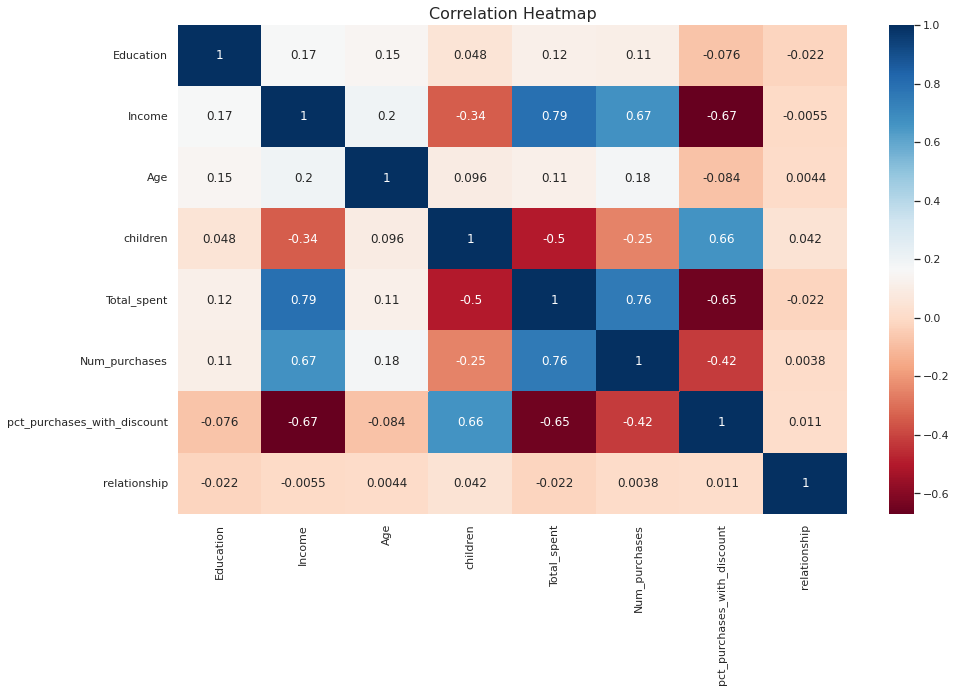

In [219]:
plt.figure(figsize=(15,9))
sns.heatmap(df.corr(),annot=True,cmap='RdBu')
plt.title('Correlation Heatmap',fontsize=16)
plt.yticks(rotation =0)
plt.show()

**Standardization**

In [220]:
sc = StandardScaler()
df_std = pd.DataFrame(sc.fit_transform(df), columns = df.columns)
display(df_std.T)

,0,1,2,3,4,5,6,7,8,9,...,2200,2201,2202,2203,2204,2205,2206,2207,2208,2209
Education,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,...,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752,0.358752
Income,0.288058,-0.260133,0.914383,-1.175705,0.295263,0.491410,0.171718,-0.859266,-1.003495,-2.151702,...,-1.278520,-1.902381,-0.331805,-1.167804,-0.814319,0.431451,0.561178,0.234280,0.804317,0.043153
Age,1.022823,1.279827,0.337478,-1.290216,-1.033212,0.166142,-0.176531,-1.375884,-0.433535,1.622500,...,-0.262199,-1.290216,-0.090862,-1.461552,-0.433535,0.166142,1.965172,-1.033212,1.108491,1.279827
children,-1.266087,1.403810,-1.266087,0.068862,0.068862,0.068862,0.068862,0.068862,0.068862,1.403810,...,1.403810,0.068862,-1.266087,-1.266087,0.068862,0.068862,2.738758,-1.266087,0.068862,1.403810
Total_spent,1.678889,-0.963559,0.281217,-0.920349,-0.307102,0.181502,-0.027900,-0.727567,-0.931983,-0.926997,...,-0.925335,-0.868830,0.734920,-0.971869,-0.958574,1.220200,-0.270540,1.054008,0.392565,-0.722581
Num_purchases,1.317852,-1.159057,0.796398,-0.898329,0.535671,0.926762,0.796398,-0.637602,-1.159057,-1.680511,...,-1.028693,-0.767966,1.578580,-1.419784,-1.419784,0.405307,0.926762,0.535671,1.057125,-0.507238
pct_purchases_with_discount,-0.542561,1.376714,-1.193744,0.626997,0.745373,-0.804281,0.091485,0.177167,-0.122720,2.876147,...,0.948304,1.376714,-0.955738,0.626997,0.626997,-0.622531,1.240402,-1.148648,-0.839840,0.831465
relationship,-1.349992,-1.349992,0.740745,0.740745,0.740745,0.740745,-1.349992,0.740745,0.740745,0.740745,...,0.740745,-1.349992,-1.349992,-1.349992,0.740745,0.740745,0.740745,-1.349992,0.740745,0.740745


**Applying PCA**

In [221]:
pca = PCA()
pca.fit(df_std)
pca.explained_variance_ratio_

array([0.42118812, 0.15892548, 0.12586838, 0.10821271, 0.09486155,
       0.04770118, 0.02495277, 0.01828981])

Text(0, 0.5, 'Cumulative Explained Variance')

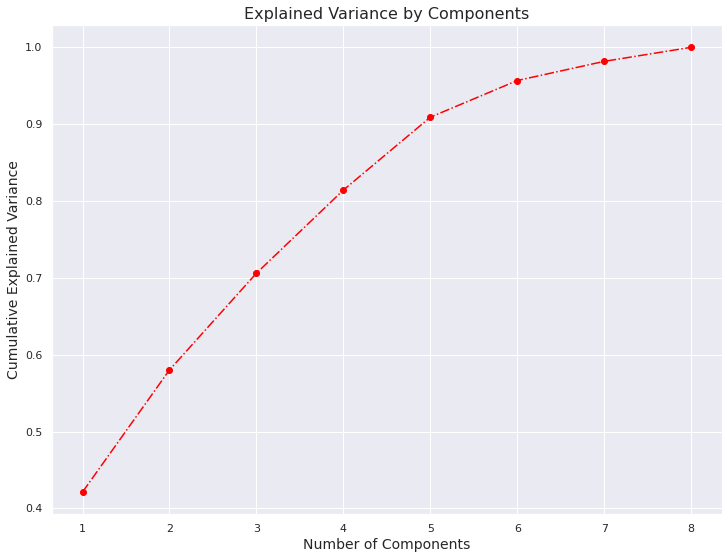

In [223]:
plt.figure(figsize = (12,9))
plt.plot(range(1,9), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '-.',color='red')
plt.title('Explained Variance by Components',fontsize=16)
plt.xlabel('Number of Components',fontsize=14)
plt.ylabel('Cumulative Explained Variance',fontsize=14)

In [224]:
# We choose 4 components  to keep 80% of the explained variance
pca = PCA(n_components = 4)
pca.fit(df_std)

PCA(n_components=4)

In [225]:
pca.components_
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns,
                           index = ['Component 1', 'Component 2', 'Component 3',
                                    'Component 4'])
df_pca_comp

,Education,Income,Age,children,Total_spent,Num_purchases,pct_purchases_with_discount,relationship
Component 1,-0.093334,-0.480023,-0.105044,0.339865,-0.501242,-0.424225,0.450467,0.013949
Component 2,-0.525450,-0.131499,-0.622153,-0.484884,-0.003927,-0.191948,-0.211768,-0.052131
Component 3,0.204922,-0.031083,-0.013904,-0.058615,-0.019081,-0.072139,-0.008706,-0.973534
Component 4,-0.813284,0.053359,0.446363,0.182283,0.053840,0.208307,0.117427,-0.207785


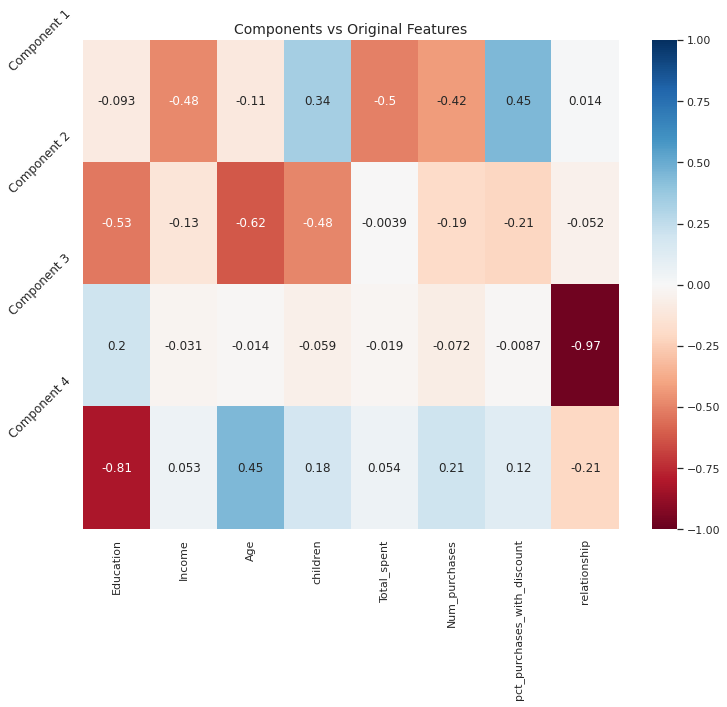

In [226]:
# Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
plt.figure(figsize=(12,9))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2,3,4], 
           ['Component 1', 'Component 2', 'Component 3', 'Component 4'],
           rotation = 45,
           fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In [227]:
scores_pca = pca.transform(df_std)

**K-means**

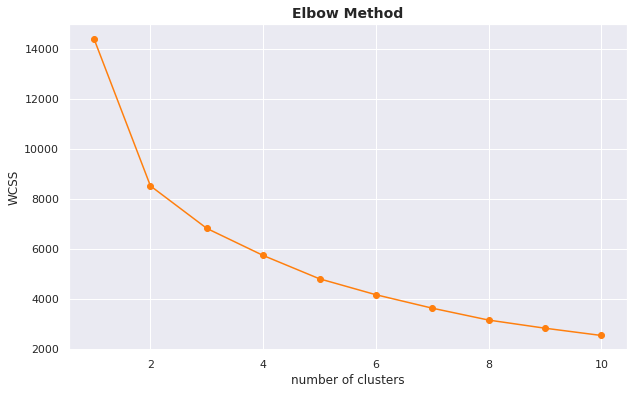

In [228]:
## Determining the ideal number of clusters: Elbow method
wcss=[]
for i in range (1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=123)
    kmeans.fit(scores_pca)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,11), wcss, marker='o', color = 'tab:orange')
plt.title('Elbow Method', fontsize = 14, fontweight = 'bold')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

The right number of clusters seems to be 3, 

let's confirm it with the silhouette  method

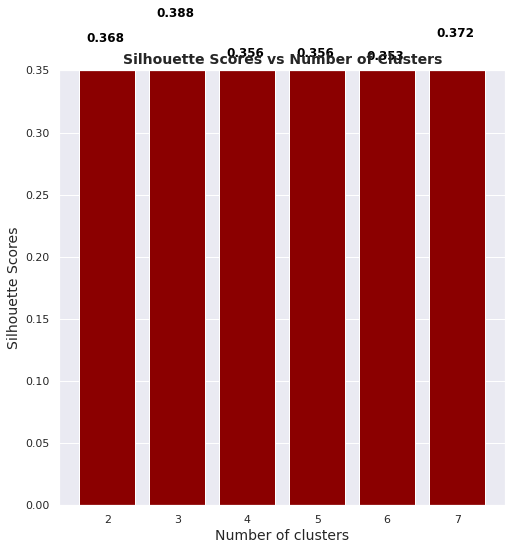

In [236]:
silhouette_scores = []

for i in range(2,8):
    m1 = KMeans(n_clusters=i, random_state=123)
    c = m1.fit_predict(scores_pca)
    silhouette_scores.append(silhouette_score(scores_pca, c))

plt.figure(figsize = (8,8))
plt.bar(range(2,8), silhouette_scores, color = 'darkred')
plt.title("Silhouette Scores vs Number of Clusters", fontsize = 14, fontweight = 'bold')
plt.xlabel('Number of clusters', fontsize = 14) 
plt.ylabel('Silhouette Scores', fontsize = 14)
plt.ylim(0,0.35)
for a, b in enumerate(silhouette_scores):
    plt.text(a + 1.7, b + 0.005, str(round(b,3)), color='black', fontweight='bold')
plt.show()

In [237]:
kmeans = KMeans(n_clusters=3, random_state=123).fit(scores_pca)
pred = kmeans.predict(scores_pca)
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
df_new = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_new.columns.values[-4: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
df_new['cluster'] = pred + 1
df_new.head()

,Education,Income,Age,children,Total_spent,Num_purchases,pct_purchases_with_discount,relationship,Component 1,Component 2,Component 3,Component 4,cluster
0,1,58138.0,64,0,1617,25,0.120000,0,-2.373330,-0.323113,1.316433,0.531074,2
1,1,46344.0,67,2,27,6,0.333333,0,2.010061,-1.626138,1.385799,0.670364,3
2,1,71613.0,56,0,776,21,0.047619,1,-1.944374,0.155405,-0.658953,-0.436183,2
3,1,26646.0,37,1,53,8,0.250000,1,1.825000,0.740075,-0.520268,-1.234823,3
4,1,58293.0,40,1,422,19,0.263158,1,0.229506,0.084017,-0.685745,-0.695987,3


In [238]:
# We calculate the means by cluster
df_segm_pca_kmeans_freq = df_new.groupby(['cluster']).mean()
df_segm_pca_kmeans_freq

,Education,Income,Age,children,Total_spent,Num_purchases,pct_purchases_with_discount,relationship,Component 1,Component 2,Component 3,Component 4
cluster,,,,,,,,,,,,
1,0.000000,36077.870968,45.746544,0.963134,259.262673,10.755760,0.228335,0.695853,1.391876,1.897398,-0.597850,1.875341
2,0.962325,71136.886975,54.649085,0.501615,1183.639397,21.202368,0.087448,0.627557,-1.883163,-0.075105,0.019927,-0.024713
3,1.000000,38415.089286,51.088346,1.335526,174.003759,10.223684,0.251590,0.651316,1.360358,-0.321394,0.104531,-0.360893


**Cluster 1 characteristics:**

-The youngest

-Lowest Income

-Undergraduate

**Cluster 2 characteristics:**

-The oldest

-Highest Income

-Mostly postgraduate

-Has the smallest number of children at home

-Spent the biggest amount of money

-Biggest number of purchases

-Very few purchases with discounts

**Cluster 3 characteristics:**

-Avergae age of 51

-Average Income

-Postgraduate

-Has the biggest number of children at home

-Spent the least ammount of money

-Made the smallest number of purchases

-A lot of purchases had discounts







**Some visualisations**

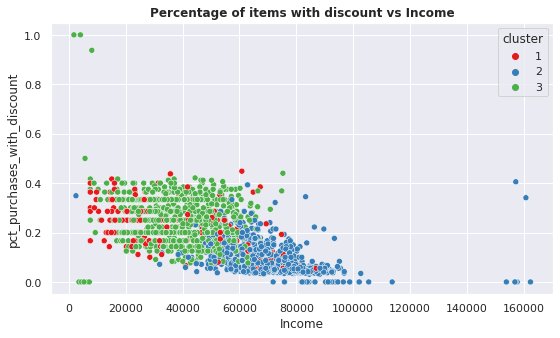

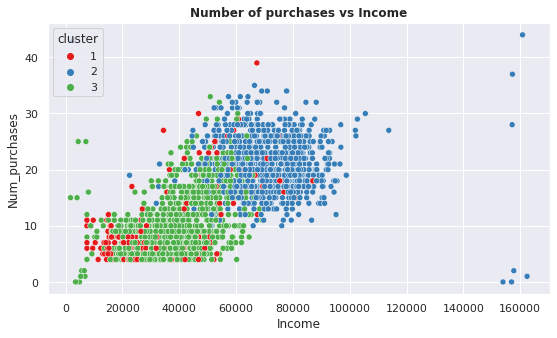

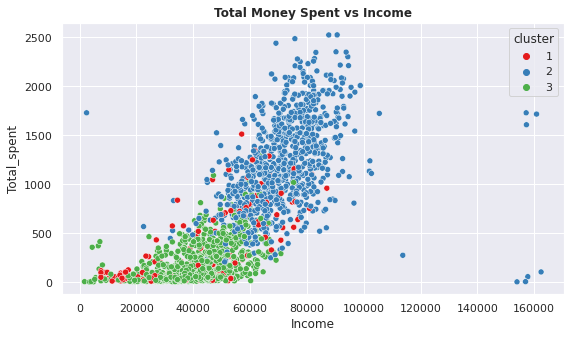

In [240]:
plt.figure(figsize = (9,5))
plt.title('Percentage of items with discount vs Income', fontweight = 'bold')
sns.scatterplot(data = df_new, x = 'Income', y = 'pct_purchases_with_discount', hue = 'cluster', palette = 'Set1')
plt.show()

plt.figure(figsize = (9,5))
plt.title('Number of purchases vs Income', fontweight = 'bold')
sns.scatterplot(data = df_new, x = 'Income', y = 'Num_purchases', hue = 'cluster', palette = 'Set1')
plt.show()

plt.figure(figsize = (9,5))
plt.title('Total Money Spent vs Income', fontweight = 'bold')
sns.scatterplot(data = df_new, x = 'Income', y = 'Total_spent', hue = 'cluster', palette = 'Set1')
plt.show()

We can see that the three clusters are clearly distinct.